Solving for a DVF: optical flow
=========================

In this example we use ImWIP to solve for an unknown DVF in the present of known images. A simple application that uses this, is optical flow: the flow of colors (or brightness levels) in a video.

There are many techniques for computing optical flow. The variational techniques all use some form of differentiated image warping, usually replaced by a regular warp with an image gradient applied to it. This example shows how exact differentiated warping gives better results.

In [1]:
import pylops
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import imwip

We load 2 frames of a well known test video for optical flow. See https://www.cs.toronto.edu/~fleet/research/Papers/ijcv-94.pdf for the origin of this video.

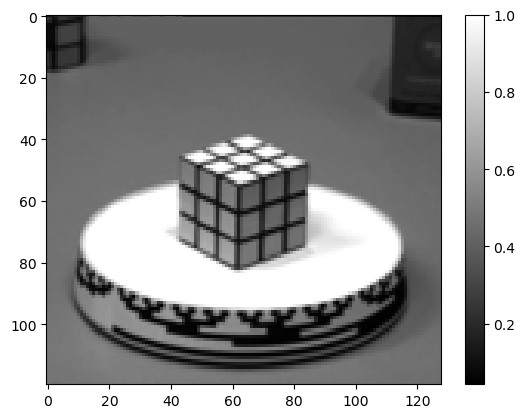

In [2]:
im1 = Image.open("im1.png").convert("L")
im2 = Image.open("im2.png").convert("L")
im1 = np.asarray(im1.resize((im1.width//2, im1.height//2)), dtype=np.float32)/255
im2 = np.asarray(im2.resize((im2.width//2, im2.height//2)), dtype=np.float32)/255
plt.imshow(im1, cmap="gray")
plt.colorbar()

We try to find the DVF $(u, v)$ that minimizes following objective function:
$$ f(u,v) = \frac{1}{2}\lVert \text{warp}(\text{im}_1, u, v) - \text{im}_2 \rVert_2^2+ \frac{a}{2} \lVert \nabla(u,v) \rVert_2^2$$
The first term enforces that this DVF deforms `im1` to look like `im2`. The second term enforces that this DVF is smooth. The parameter `a` regulates the relative importance of the terms.

In [3]:
# construct gradient operator for regularization term
G = pylops.Gradient(im1.shape, kind="forward", dtype=np.float32)
G = pylops.BlockDiag([G, G])

# weight of the regularization term
a = 5e-3

In [4]:
# objective function (for reference, only its gradient is used by the optimizer)
def f(uv):
    u, v = uv.reshape(2, *im1.shape)
    res = imwip.warp(im1, u, v) - im2
    return 1/2 * np.dot(res.ravel(), res.ravel()) + a/2 * np.linalg.norm(G @ uv)

The gradient of this objective is given by
$$\nabla f(u, v) = \left(\frac{d}{d(u,v)} \text{warp}(\text{im}_1, u, v)\right)^T (\text{warp}(\text{im}_1, u, v) - \text{im}_2) + a \nabla^T (\nabla(u, v))$$

In [5]:
# gradient of objective function
def grad_f(uv):
    u, v = uv.reshape(2, *im1.shape)
    warped = imwip.warp(im1, u, v)
    res = warped - im2
    diff_warp = imwip.diff_warping_operator_2D(im1, u, v)
    return diff_warp.T @ res.ravel() + a * (G.T @ G @ uv)

Using this gradient, we can solve for `u` and `v`:

In [6]:
# initial guess
uv0 = np.zeros(im1.size*2, dtype=np.float32)

# optimize
uv = imwip.barzilai_borwein(grad_f, uv0, max_iter=100, verbose=True)
u, v = uv.reshape(2, *im1.shape)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 854.10it/s]


Using `flow_vis`, this DVF can be visualized in color.

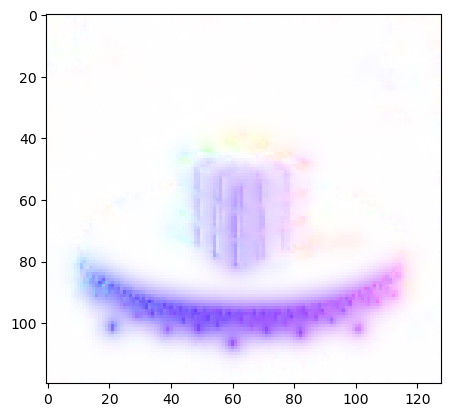

In [7]:
import flow_vis # pip install flow-vis
flow = flow_vis.flow_uv_to_colors(u, v)
plt.imshow(flow)

The direction of the flow can be read from this colormap:

In [ ]:
plt.